# Image Preprocessing for TensorFlow (Part 3/4)
Download | Structure | **Preprocessing** | Training

<pre>
</pre>

## Overview
* #### Dependencies
* #### Load data with TensorFlow Datasets
* #### Tensorflow resize and augmentation
* #### Save the Datasets to TFRecord Format
* #### Upload Datasets to S3

<pre>
</pre>

## Dependencies
___
For this guide we'll use the SageMaker Python SDK version 2.9.2. By default, SageMaker Notebooks come with version 1.72.0. Other guides provided by Amazon may be set up to work with other versions of the Python SDK so you may wish to roll-back to 1.72.0. In addition to updating the SageMaker SDK we'll also update TensorFlow to 2.3.0 and install TensorFlow Datasets.

We will also debug our code by training on the instance running this notebook (Local Mode). In order to run through one epoch of training in a reasonable amount of time I advise using a notebook backed by a p2.xlarge instance. Once youre script has completely run locally and all bugs have been ironed out, then you can switch back to a smaller instance.

#### Update SageMaker Python SDK and TensorFlow

In [2]:
import sys
original_sagemaker_version = !conda list | grep -E "sagemaker\s" | awk '{print $2}'
original_tensorflow_version = !conda list | grep -E "tensorflow\s" | awk '{print $2}'
!{sys.executable} -m pip install -q "sagemaker==2.9.2" "tensorflow-serving-api==2.3.0" "tensorflow==2.3.0" "tensorflow-datasets"

ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.1 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
import uuid
import pickle
import numpy as np
import sagemaker
import boto3
from tqdm import tqdm
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [14]:
print(f'sagemaker  updated  {original_sagemaker_version[0]} -> {sagemaker.__version__}')
print(f'tensorflow updated  {original_tensorflow_version[0]} -> {tf.__version__}')

sagemaker  updated  1.72.1 -> 2.9.2
tensorflow updated  2.1.0 -> 2.3.0


<pre>
</pre>

## Loading Data with TensorFlow Datasets
___
TensorFlow Datasets is a helpful module for getting your data ready for use with TensorFlow and Keras by generating wrapper for the dataset and each record in it. This wrapper has mathods which allow you to easily control sharding, batch size, and prefetching as well data transformations and augmentations. TensorFlow Datasets can also import many external datasets from the internet which come already structured and annoatated. However, for this guide we'll assume that your dataset isn't perfectly organized from the get-go.  

#### Create the `ImageFolder` builder

`tfds.ImageFolder` is a pre-made builder for reading image data in the common folder structure we created previously.

In [3]:
image_folder = tfds.ImageFolder('./data_structured')

In [4]:
image_folder.info

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
    }),
    total_num_examples=2750,
    splits={
        'test': 275,
        'train': 2200,
        'val': 275,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)

Now that your image data is cataloged, you can generate a TensorFlow dataset for traing and validation. These datasets are very flexible can by be used for processing, augmentation and training with just TensorFlow or with Keras as well.

<pre>
</pre>

## Preprocessing with TensorFlow
___

In this step we create separate datasets for training and validation then define the necessary transformations required before our algorithm can train on the data. We will also define image augmentations which allow us to get the most out of the data we have and improve training effectiveness.

#### Create Training and Validation Datasets
The `.as_dataset()` method is a conveient way generating `(image, label)` tuples required by the training algorithm
* split - designates the data split for this dataset
* shuffle_files - mix the order of files
* as_supervised - discards any metadata just keeping the (image, label) tuple

In [5]:
train_ds = image_folder.as_dataset(
    split=['train'], 
    shuffle_files=True, 
    as_supervised=True)[0]

# create a sample which is easy to iterate through for example purposes
sample_ds = train_ds.take(100).as_numpy_iterator()

#### Define Resize Transformation
Before going to the GPU for training, all image data must have the same dimensions for length, width and channel. Typically, algorithms use a square format so the length and width are the same and many pre-made datasets areadly have the images nicely cropped into squares. However, most real-world datasets will begin with images in many different dimensions and ratios. In order to prep our dataset for training we need to resize and crop the images if they aren't already square. 

This transformation is deceptivley simple because if we want to keep the images from looking squished or stretched, we need to crop it to a square *and* we want to make sure the important object in the image doesn't get cropped out. Unfortunately, there is no easy way to make sure each crop is optimal so we typically choose a center crop which works well most of the time.

In [6]:
def resize(image, label):
    image = tf.image.resize(image, (400, 400), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, 244, 244)
    return (image, label)

Re-run the cell below to see the resize transform on different image

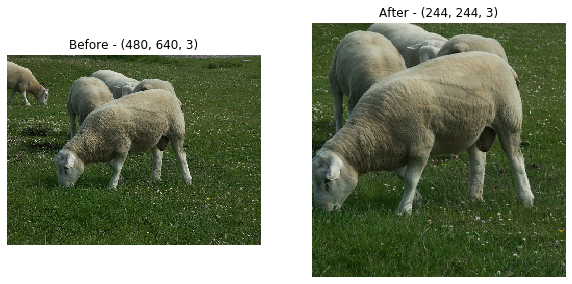

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, label = next(sample_ds)
image_resized = resize(image, label)[0]
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title(f'Before - {image.shape}')
ax[1].imshow(image_resized/255)
ax[1].axis('off')
ax[1].set_title(f'After - {image_resized.shape}');

#### Define Data Augmentations
An easy way to improve trainging is to randomly augment the images to help our training algorithm generalize better. Threre are many augmentations to choose from, but keep in mind that the more we add to our augment function, the more processing will be required before we can send the image to the GPU for training. Also, it's important to note that we don't need to augment the validation data because we want to generate a prediction on the image as it is.

In [17]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.1)
    return (image, label)

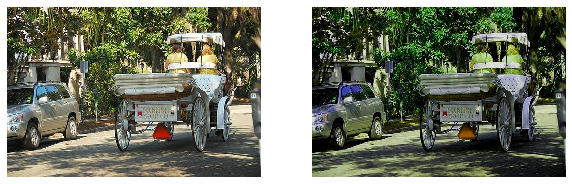

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, label = next(sample_ds)
image_aug = augment(image, label)[0]
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(image_aug)
ax[1].axis('off');

#### Apply Transformations to the Datasets
The training data set will get the resize and augment functions applied to it, but the validation dataset only gets resized because it's not directly used for training. When we call the `.map()` method to apply the transformation to each record. However, it doesn't actually transform the image yet. Rather, the transformation will be fully applied by the CPU right before it gets sent to the GPU for training. This is nice beause we can experiment quickly without having to wait for all the images to be transformed.

You may be wondering why we're applying the transformations randomly. This is done because our training algorithm will cycle through the data in epochs. Each epoch it will get a chance to view the image again so instead of sending the same image through each time, we'll apply a random augmentation. Ideally, we'd let the algorithm see all versions of the image each epoch, but this would scale the size of the training dataset by the number of augmentations. Scaling the data storage and training time by that factor isn't worth the relatively minor changes introduced into the dataset.

In [19]:
train_ds = train_ds.map(resize).map(augment)

#### Visualize the Transforms
Just to make sure everything is working we can apply some transformations on a few images and view them to make sure the output looks good.

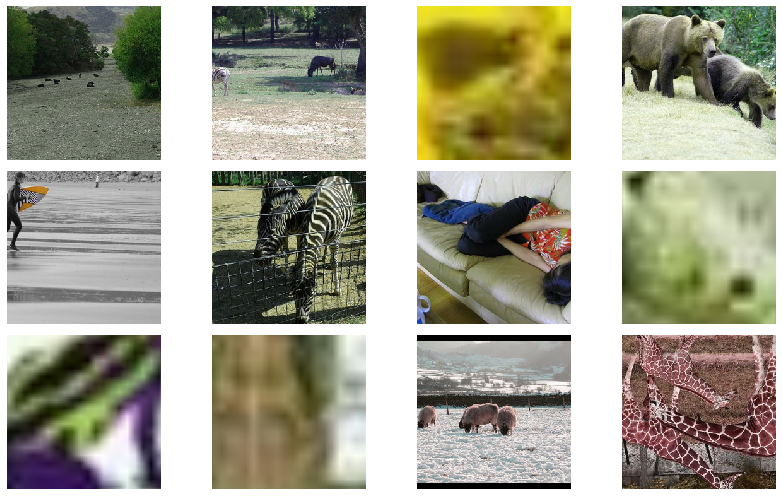

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(12, 7))

for ax in axs.flatten():
    sample = next(iter(train_ds))
    ax.imshow(tf.cast(sample[0], dtype=tf.uint8))
    ax.axis('off')
    
plt.tight_layout()

<pre>
</pre>

## Save the Datasets to TFRecord Format
___
TensorFlow has its own record format which makes moving and training on image data much easier. The format is called TFRecord and it basically converts your image data into one or more binary chunks that are much easier to read process than thousands of individual files. One downside to the TFRecord format is that the images it saves are uncompressed so if you have large jpeg images this can really add up to a large filesize. One solution is to use TFRecord's built-in compression, but you'll still have to uncompress the files during trainging which may slow training down. The solution we'll implement here is preform the resizing transform before converting to a TFRecord so the uncompressed image size is much smaller.

#### Define Helper Fuctions

In [22]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _image_as_bytes_feature(image):
    """Returns a bytes_list from an image tensor."""
    
    if image.dtype != tf.uint8:
        # `tf.io.encode_jpeg``requires tf.unit8 input images, with values between
        # 0 and 255. We do the conversion with the following function, if needed:
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    
    # We convert the image tensor back into a byte list...
    image_string = tf.io.encode_jpeg(image, quality=90)
    
    # ... and then into a Feature:
    return _bytes_feature(image_string)

def image_example(image_tensor, label):
    image_shape = image_tensor.shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _image_as_bytes_feature(image_tensor),
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

#### Define Resize and Rescale Transformation

In [23]:
def resize_rescale(image, label):
    image = tf.image.resize(image, (400, 400), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, 244, 244)
    image = image / 255.0
    return (image, label)

#### Write Data to TFRecord Files

In [24]:
tfrecord_dir = pathlib.Path('./data_tfrecord')
tfrecord_dir.mkdir(exist_ok=True)

In [25]:
train_ds = image_folder.as_dataset(split=['train'], shuffle_files=True, as_supervised=True)[0]
val_ds = image_folder.as_dataset(split=['val'], shuffle_files=True, as_supervised=True)[0]
test_ds = image_folder.as_dataset(split=['test'], shuffle_files=True, as_supervised=True)[0]

train_ds = train_ds.map(resize_rescale)
val_ds = val_ds.map(resize_rescale)
test_ds = test_ds.map(resize_rescale)

for name, data_split in zip(['train', 'val', 'test'], [train_ds, val_ds, test_ds]):
    record_file = f'data_tfrecord/{name}.tfrecord'
    with tf.io.TFRecordWriter(record_file) as writer:
        for image_tensor, label in tqdm(data_split):
            tf_example = image_example(image_tensor, label)
            writer.write(tf_example.SerializeToString())

100%|██████████| 275/275 [00:01<00:00, 225.93it/s]


<pre>
</pre>

## Upload Datasets to S3
___

#### Create an S3 Bucket for Project if it doesn't exist

In [29]:
if pathlib.Path('pickled_data/tensorflow_bucket_name.pickle').exists():
    with open('pickled_data/tensorflow_bucket_name.pickle', 'rb') as f:
        bucket_name = pickle.load(f)
        print('Bucket Name:', bucket_name)
else:
    bucket_name = f'sagemaker-tensorflow-ic-{str(uuid.uuid4())}'
    s3 = boto3.resource('s3')
    region = sagemaker.Session().boto_region_name
    bucket_config = {'LocationConstraint': region}
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration=bucket_config)
    
    with open('pickled_data/tensorflow_bucket_name.pickle', 'wb') as f:
        pickle.dump(bucket_name, f)
    print('Bucket Name:', bucket_name)

Bucket Name: sagemaker-tensorflow-ic-ebb3105c-a8fb-4b81-91ed-8df68486d738


#### Upload .rec files

In [30]:
s3_uploader = sagemaker.s3.S3Uploader()

for data_split in ['train', 'val']:
    data_path = f'data_tfrecord/{data_split}.tfrecord'
    data_s3_uri = s3_uploader.upload(
        local_path=data_path, 
        desired_s3_uri=f's3://{bucket_name}/data/{data_split}')

<pre>
</pre>

### Rollback to default version of SDK and TensorFlow
Only do this if you're done with this guide and want to use the same kernel for other notebooks with an incompatible version of the SageMaker SDK or TensorFlow.

In [15]:
# print(f'Original version: sagemaker {original_sagemaker_version[0]}, tensorflow {original_tensorflow_version[0]}')
# print(f'Current version:  sagemaker {sagemaker.__version__}, tensorflow {tf.__version__}')
# print('')
# print(f'Rolling back to sagemaker {original_sagemaker_version[0]}, tensorflow {original_tensorflow_version[0]}')
# print('Restart notebook kernel to use changes.')
# print('')
# s = f'sagemaker=={original_sagemaker_version[0]} tensorflow-serving-api=={original_tensorflow_version[0]} tensorflow=={original_tensorflow_version[0]}'
# !{sys.executable} -m pip install -q {s}

<pre>
</pre>